# CAB420, Regression, Example 2: Regularised Regression
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example, we'll explore:
* A quick recap of linear regression, and linear regression using lots of data, and lots of variables
* L1 (Lasso) regression
* L2 (ridge) regression

## Too Long; Didn't Read
* Linear regression can become challenging when we have a lot of variables. In particular, tuning the model can become hard due to the sheer volume of variables which require inspection. Models are also more likely to overfit in such scenarios.
* Regularisation is a process that applies a small penalty to the model, such that simpler models are favoured. In the case of regression, a simpler model is considered to be one with smaller and/or fewer weights.
* Ridge using L2 regularisation, which is the sum of the squares of the coefficients, to regularise the model. This approach can supress, but not eliminate terms.
* Lasso uses L1 regularisation, which is the sum of the absolute value of the coefficients, to regularise the model. This approach can allow the regularisation to remove terms for the model entirely
* Often when fitting data, we may wish to standardise the data first. Standardising involves subtracting the mean, and dividing by the standard deviation for each dimension. The end result is that all dimensions have 0 mean and 1 standard deviation. This means that all have the same scale, which can lead to an improved fit and better visualisation of lasso and ridge traces.
* p-values don't exist for ridge and lasso, but our other evaluation tools such as qqplots and $R^2$ values still work. Remember to only calculate things like this on the training data.

In [30]:
import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures

## The Data
For data we'll use travel time data from Brisbane roads. This data contains average travel time over 15 minute intervals along key transport corridors. For simplicity, the data has already been aggregrated into one hour intervals, and all files merged. The original data can be found [here](https://www.data.qld.gov.au/dataset/travel-times-for-key-priority-routes).

Each row of our data contains a timestamp that indicates the end of the sampling interval, and a series of values for travel corridors in Brisbane. Each of these values represents the average travel time along that corridor in the past hour.

We'll start by loading our data, and dropping rows that contain NaNs (i..e missing data). For simplicity, we'll only take the first 10 columns too.

In [31]:
data = pandas.read_csv('./Bluetooth_hourly_full.csv')
data_to_use = data.iloc[:,0:10].dropna()
print(data_to_use.shape)

(9563, 10)


As a sanity check, we'll have a look at the data. Here, we're using:
* head, to print the first few rows
* describe, to print some stats about the data

In [32]:
print(data_to_use.head(10))
data_to_use.describe()

              INTERVAL_END  x_1098__1056_  x_1058__1059_  x_1057__1056_  \
0   01/07/2016 12:00:00 AM        98.9900        70.2250        56.7000   
1   01/07/2016 01:00:00 AM       105.0500        75.5675        54.6400   
4   01/07/2016 04:00:00 AM       100.1100        69.6125        54.5775   
5   01/07/2016 05:00:00 AM       103.7875        77.6125        66.1925   
6   01/07/2016 06:00:00 AM       115.1375        90.5425        60.0875   
7   01/07/2016 07:00:00 AM       141.3975        88.2150        60.9850   
8   01/07/2016 08:00:00 AM       172.2625        91.5725        64.6425   
9   01/07/2016 09:00:00 AM       184.7125        84.4000        73.3400   
10  01/07/2016 10:00:00 AM       294.5600       108.5450        92.7975   
11  01/07/2016 11:00:00 AM       269.7025       109.9800       101.2125   

    x_1017__1007_  x_1115__1015_  x_1015__1115_  x_1103__1061_  x_1135__1231_  \
0      177.000000        53.3700      42.740000        61.5625        21.9125   
1      180.4

,x_1098__1056_,x_1058__1059_,x_1057__1056_,x_1017__1007_,x_1115__1015_,x_1015__1115_,x_1103__1061_,x_1135__1231_,x_1260__1261_
count,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000
mean,163.671733,105.009541,83.498366,190.255989,50.717306,46.415159,96.390382,32.479224,464.363302
std,73.525574,48.601985,24.318463,78.412377,23.168044,10.871494,32.558044,25.293008,238.667847
min,80.830000,60.850000,35.952500,157.040000,38.180000,20.850000,28.080000,3.480000,321.250000
25%,110.522500,83.323750,65.172917,172.500000,44.091250,41.767500,74.607500,23.683750,363.000000
50%,141.625000,93.915000,77.995000,178.447500,46.627500,42.790000,86.492500,24.525000,381.440000
75%,188.803750,103.118750,95.843750,183.821250,47.641250,47.000000,112.535000,26.533750,435.048750
max,805.845000,621.352500,442.857500,2929.447500,728.000000,417.865000,426.975000,379.840000,4711.307500


### Data Exploration and Pre-Processing

One limitation of the data in this format is that our intersection names are a bit meaningless, x_1017__1007_ doesn't really tell us much. We have another file that contains details of the corridors, so let's pull out data from that just so that we can tell what we're looking at.

Note that this data uses a different format for the corridor names, x_1017__1007_ becomes 1017->1007, so we'll need to clean up our column names if we want to do this at least somewhat automatically (which we do).

In [33]:
# NOTE: This bit of code is not really all that important, it's just to help explore the data
# load the data
data_details = pandas.read_csv('./priority-route-link-details-october-2021.csv')

# setup the bits of text in each key that we need to change to get our format switched over 
text_to_change = {'x_' : '', '__' : '->', '_': ''}
# simple function to do the conversion, we could use a lambda function here too
def replace_all(input_string, text_to_change):
    for k, v in text_to_change.items():
        input_string = input_string.replace(k, v)
    return input_string

# pull out and convert the intersection names
intersection_names = [replace_all(s, text_to_change) for s in data_to_use.columns[1:]]
print(data_details['LINK_DETAILS'].str.contains('|'.join(intersection_names)))
print('|'.join(intersection_names))
print(data_details['LINK_DETAILS'].str)
# pull out those intersections from the table
intersection_details = data_details.where(data_details['LINK_DETAILS'].str.contains('|'.join(intersection_names))).dropna()
intersection_details

0      False
1      False
2      False
3       True
4      False
       ...  
213    False
214    False
215    False
216    False
217    False
Name: LINK_DETAILS, Length: 218, dtype: bool
1098->1056|1058->1059|1057->1056|1017->1007|1115->1015|1015->1115|1103->1061|1135->1231|1260->1261


,LINK_DETAILS,ORIGIN_DESC,ORIGIN_LONGITUDE,ORIGIN_LATITUDE,DEST_DESC,DEST_LONGITUDE,DEST_LATITUDE
3,1015->1115,Bruce Highway and Dohles Rocks Road Northbound...,153.018289,-27.276611,Bruce Highway Murrumba Downs VMS (MET001),153.018229,-27.265953
33,1135->1231,CCTV1406 Pacific Motorway at Hawthorne Street,153.032469,-27.487992,South of Captain Cook Bridge (CS25),153.030813,-27.482910
50,1057->1056,Intersection Gympie and Hamilton Roads (M1116),153.030897,-27.385892,Intersection Gympie and Rode Roads (M1113),153.030954,-27.393409
82,1260->1261,Pacific Motorway NB south of Logan River (M5702),153.196872,-27.700087,Pacific Motorway and Paradise Road (M5271),153.137379,-27.638481
108,1017->1007,At Boundary Road Interchange (M7084),152.991910,-27.211420,Bruce Highway near Anzac Ave Interchange,153.016018,-27.245606
110,1103->1061,Sandgate Road Interection with Toombul Shoppin...,153.059800,-27.409040,Intersection of Sandgate Road and Junction Roa...,153.058345,-27.415987
168,1098->1056,Intersection of Gympie Road and Sadlier Street...,153.032472,-27.406837,Intersection Gympie and Rode Roads (M1113),153.030954,-27.393409
170,1115->1015,Bruce Highway Murrumba Downs VMS (MET001),153.018229,-27.265953,Bruce Highway and Dohles Rocks Road Northbound...,153.018289,-27.276611
193,1058->1059,Intersection Gympie and Webster Roads (M1119),153.023189,-27.373478,Intersection Gympie/Albany Creek/Robinson Rds ...,153.017151,-27.364449


Above we have our intersections - note that these are not in the same order as they are in the columns in our main data table.

We can see that they are mostly on the north side of the city, but they are not all in one nice little patch of Brisbane. For our modelling, this information is not really critical, but it might help explain some of what we observe later on. Let's say we're going to try to predict our last entry in that list (1058->1059, starting at the intersection of Gympie and Webster roads). Other intersections on Gympie road (with Hamilton road, with Rode road) are likely to have a far greater influence than the counter on the Pacific Mototway, which is on the NSW side (i.e. the wrong side) of the river. Having additional knowledge of our predictors can help us make sense of what we see later on.

We could also use a variety of plots to help explore the data. We'll use two types of plot:
* A line plot of each series, just to get a feel for what's in the data
* A box plot, to get a summary of data structure

Note that in both of these plots I'm omitting the first column (the end of the time interval).

In [34]:
print(data_to_use.iloc[:,1:].transpose())
data_to_use.shape

                  0           1         4         5         6         7      \
x_1098__1056_   98.9900  105.050000  100.1100  103.7875  115.1375  141.3975   
x_1058__1059_   70.2250   75.567500   69.6125   77.6125   90.5425   88.2150   
x_1057__1056_   56.7000   54.640000   54.5775   66.1925   60.0875   60.9850   
x_1017__1007_  177.0000  180.443333  175.0550  178.2125  180.6150  178.4050   
x_1115__1015_   53.3700   53.317500   50.0250   48.3450   48.8050   47.7825   
x_1015__1115_   42.7400   44.043333   40.9600   40.4500   40.8350   41.2650   
x_1103__1061_   61.5625   62.000000   61.4750   65.6650   86.9025   79.2100   
x_1135__1231_   21.9125   23.085000   22.1025   22.3600   24.9950   26.0900   
x_1260__1261_  389.1650  351.165000  350.5200  422.4500  410.5075  393.4650   

                  8         9         10        11     ...     28670  \
x_1098__1056_  172.2625  184.7125  294.5600  269.7025  ...  146.2825   
x_1058__1059_   91.5725   84.4000  108.5450  109.9800  ...   90.1

(9563, 10)

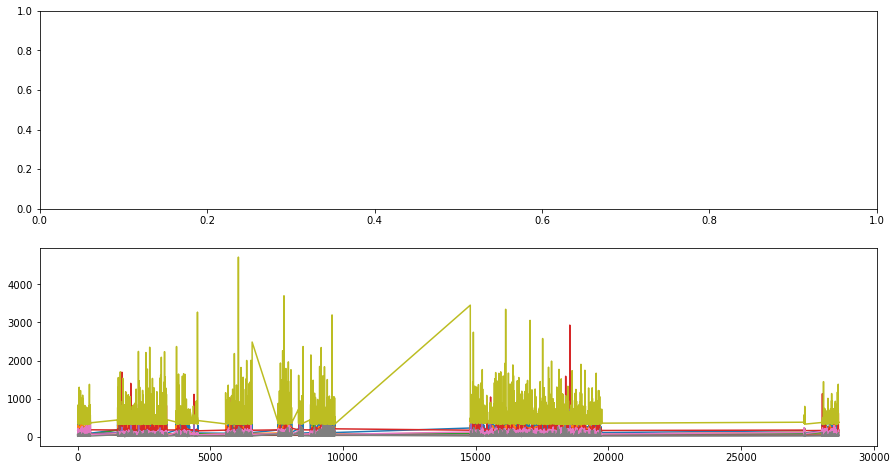

In [35]:

fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(2, 1, 1)
# ax.boxplot(data_to_use.iloc[:,1:].transpose())
ax = fig.add_subplot(2, 1, 2)
ax.plot(data_to_use.iloc[:,1:])

From the box plot we can see:
* Most data samples lie within a small range for each series
* All series have a fair number of outliers, all on the high side of things. This makes sense, and would represent peak hour traffic and when there are accidents, or bad weather.

The line plot shows similar things, but we also have these large gaps in the plot. This looks like an error in the data, but is in fact just down to the way that pandas handles the table index. After we removed the nans (way back at the top), we didn't change the index. If we look at the first few rows, we can see that the index (the left most column) skips some numbers - these are rows that were dropped. 

In [36]:
print(data_to_use.head(10))

              INTERVAL_END  x_1098__1056_  x_1058__1059_  x_1057__1056_  \
0   01/07/2016 12:00:00 AM        98.9900        70.2250        56.7000   
1   01/07/2016 01:00:00 AM       105.0500        75.5675        54.6400   
4   01/07/2016 04:00:00 AM       100.1100        69.6125        54.5775   
5   01/07/2016 05:00:00 AM       103.7875        77.6125        66.1925   
6   01/07/2016 06:00:00 AM       115.1375        90.5425        60.0875   
7   01/07/2016 07:00:00 AM       141.3975        88.2150        60.9850   
8   01/07/2016 08:00:00 AM       172.2625        91.5725        64.6425   
9   01/07/2016 09:00:00 AM       184.7125        84.4000        73.3400   
10  01/07/2016 10:00:00 AM       294.5600       108.5450        92.7975   
11  01/07/2016 11:00:00 AM       269.7025       109.9800       101.2125   

    x_1017__1007_  x_1115__1015_  x_1015__1115_  x_1103__1061_  x_1135__1231_  \
0      177.000000        53.3700      42.740000        61.5625        21.9125   
1      180.4

We can use reset_index to re-number the rows and this will make our plot look more as expected. Note that I'm using drop=True in this call, to prevent pandas from inserting a new column (index) into the table with the original indicies. Sometimes however you may want this, but I don't want it here.

In [37]:
data_to_use.reset_index(inplace=True, drop=True)
data_to_use.head(10)

,INTERVAL_END,x_1098__1056_,x_1058__1059_,x_1057__1056_,x_1017__1007_,x_1115__1015_,x_1015__1115_,x_1103__1061_,x_1135__1231_,x_1260__1261_
0,01/07/2016 12:00:00 AM,98.9900,70.2250,56.7000,177.000000,53.3700,42.740000,61.5625,21.9125,389.1650
1,01/07/2016 01:00:00 AM,105.0500,75.5675,54.6400,180.443333,53.3175,44.043333,62.0000,23.0850,351.1650
2,01/07/2016 04:00:00 AM,100.1100,69.6125,54.5775,175.055000,50.0250,40.960000,61.4750,22.1025,350.5200
3,01/07/2016 05:00:00 AM,103.7875,77.6125,66.1925,178.212500,48.3450,40.450000,65.6650,22.3600,422.4500
4,01/07/2016 06:00:00 AM,115.1375,90.5425,60.0875,180.615000,48.8050,40.835000,86.9025,24.9950,410.5075
5,01/07/2016 07:00:00 AM,141.3975,88.2150,60.9850,178.405000,47.7825,41.265000,79.2100,26.0900,393.4650
6,01/07/2016 08:00:00 AM,172.2625,91.5725,64.6425,179.200000,47.7950,41.152500,62.8400,62.9025,370.8425
7,01/07/2016 09:00:00 AM,184.7125,84.4000,73.3400,183.095000,48.3325,41.075000,69.9350,30.0600,386.0100
8,01/07/2016 10:00:00 AM,294.5600,108.5450,92.7975,182.455000,47.5625,42.780000,97.3025,23.8225,377.7050
9,01/07/2016 11:00:00 AM,269.7025,109.9800,101.2125,181.127500,47.1650,42.617500,140.5675,24.4450,374.9700


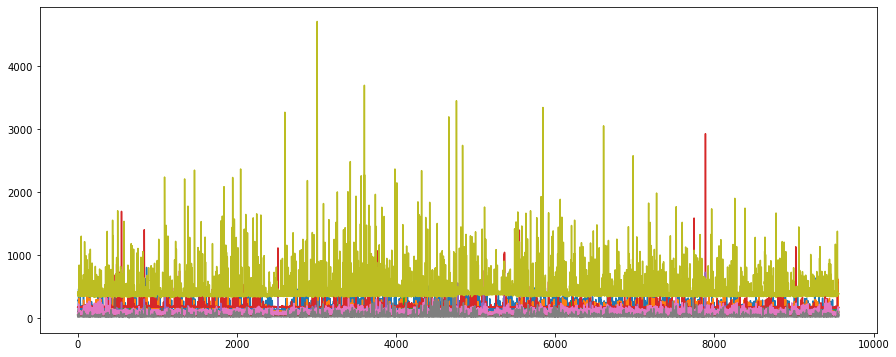

In [38]:
fig = plt.figure(figsize=[15, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(data_to_use.iloc[:,1:])

Our plot now contains no missing data, as we can get a sense of what our data looks like (though plotting this as individual data series would be clearer, we're only trying to get a sense of the data here, so it's not critical). That said, you could argue that it makes sense to leave the index as it was, as it allows you to understand where rows have been removed and the plot helps us visualise how much data has been lost. However, there may be cases where you need to reset the index to make later operations easier.

One thing we can clearly see here is that each series has it's own floor which would be closely linked to the physical distance between the points being measured. This is potentially an issue later on as this scale can impact the values learned for our regression when we apply regularisation.

#### Timestamps

Let's now deal with the timestamp column. We can convert the whole column to a datetime type using pandas. From here, we can manipulate these as dates and times. For our purposes, we really don't .need to do anything fancy. All we'll do is pull out all the hours, and we can use this as a categorical variable in our model so our model can have some concept of time of day. We could do something similar with day of the week so the model understands weekdays and weekends, but we'll leave that as something that you could do in your own time if you're interested

In [39]:
dt = pandas.to_datetime(data_to_use.iloc[:,0])
hours = [d.hour for d in dt]

data_to_use.iloc[:,0] = hours


In [40]:
data_to_use.iloc[:,0:1].describe()

,INTERVAL_END
count,9563.000000
mean,12.737844
std,6.165650
min,0.000000
25%,8.000000
50%,13.000000
75%,18.000000
max,23.000000


We can see that we've replaced that column of strings with numbers. Now we need to convert the data to a categorical. 

In this example, we're going to do things a bit differently. I'm not going to use the formula API, so I need to create dummy columns for the categoricals, and merge this with the main table. This means that rather than have one column for the categorical, I'll have 23 (number of possible options, 24, minus 1). I'll do this by:
* create 23 dummy columns. Each column will be 1 or 0. If all columns are 0, it means that the 24th class is effectivley 1
* merge these 23 columns with the rest of data
* add a constant term (to learn the intercept) to the data frame

At the same time we're doing this, we'll split the data into X (predictors) and Y (response) variables. Our response is going to the be the last of our predictors (x_1260__1261_) which is our Pacific Motorway data series (i.e. quite geographically disjoint from the rest of our data).

In [41]:
dummies = pandas.get_dummies(data_to_use["INTERVAL_END"].astype("category"), drop_first=True)
X = pandas.concat([data_to_use.iloc[:,1:-1], dummies], axis=1)
X = sm.add_constant(X)
Y = data_to_use.iloc[:,-1]
print(X)
print(Y)

      const  x_1098__1056_  x_1058__1059_  x_1057__1056_  x_1017__1007_  \
0       1.0        98.9900        70.2250      56.700000     177.000000   
1       1.0       105.0500        75.5675      54.640000     180.443333   
2       1.0       100.1100        69.6125      54.577500     175.055000   
3       1.0       103.7875        77.6125      66.192500     178.212500   
4       1.0       115.1375        90.5425      60.087500     180.615000   
...     ...            ...            ...            ...            ...   
9558    1.0       139.1175       120.6800      78.592500     168.372500   
9559    1.0       122.0900       117.0700     105.675000     173.613333   
9560    1.0       112.3200       114.0250      61.807500     168.453333   
9561    1.0       108.3925       105.2150      69.160000     177.823333   
9562    1.0       102.2300        91.8425      53.533333     166.835000   

      x_1115__1015_  x_1015__1115_  x_1103__1061_  x_1135__1231_  1  ...  14  \
0           53.3700

In [42]:
print(X.shape)
print(Y.shape)
pandas.get_dummies(data_to_use["INTERVAL_END"].astype("category"))

(9563, 32)
(9563,)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Data Splitting

We now need to split our data into:
* Train
* Validation
* Test

We'll use 70% for training, and 15% for testing and validation. We'll also just split the data sequentially (i.e. first 70% is train, etc).

In [43]:
num_samples = data_to_use.shape[0]
training_samples = int(num_samples*0.7)
validation_samples = int(num_samples*0.15)
X_train = X.iloc[0:training_samples, :]
Y_train = Y.iloc[0:training_samples]
X_val = X.iloc[training_samples:(training_samples + validation_samples), :]
Y_val = Y.iloc[training_samples:(training_samples + validation_samples)]
X_test = X.iloc[(training_samples + validation_samples):, :]
Y_test = Y.iloc[(training_samples + validation_samples):]

As a sanity check, we can print out the shape of the data sets to make sure that we didn't get something wrong.

In [44]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(6694, 32)
(6694,)
(1434, 32)
(1434,)
(1435, 32)
(1435,)


## A Linear Model

Let's train a model. We'll start with a simple linear model. That means that what we're trying to optimise is this:

$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2$

where
* $y_i$ is the actual value we're trying to predict (ground truth);
* $\hat{y_i}$ is what the model predicts;
* $i$ is a sample and $M$ is the number of samples that we have (i.e. how much data);
* $j$ is a dimension of the data, and $P$ is the number of dimensions that we have;
* $w_j$ is the learned weight for the th dimension (i.e. it's one of our regression coefficients); and
* $x_{ij}$ is the $i$ th dimension of the $j$ th input sample.

In [45]:
model = sm.OLS(Y_train, X_train)
trained_model = model.fit()
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          x_1260__1261_   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     73.95
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        06:27:34   Log-Likelihood:                -45686.
No. Observations:                6694   AIC:                         9.144e+04
Df Residuals:                    6662   BIC:                         9.165e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           119.9389     26.334      4.555      0.000      68.316     171.562
x_1098__1056_     0.0462      0.057      0.804      0.422      -0.066       0.159
x_1058__1059_     0.2443      0.082      2.980      0.003       0.084       0.405
x_1057__1056_     2.7346      0.167     16.356      0.000       2.407       3.062
x_1017__1007_     0.2636      0.048      5.492      0.000       0.169       0.358
x_1115__1015_     1.3343      0.161      8.268      0.000       1.018       1.651
x_1015__1115_     0.1983      0.272      0.730      0.466      -0.334       0.731
x_1103__1061_    -0.1058      0.134     -0.792      0.429      -0.368       0.156
x_1135__1231_     0.7734      0.112      6.891      0.000       0.553       0.993
1               -50.3136     38.054     -1.322      0.186    -124.912      24.284
2                33.6517     43.325      0.777      0.437     -51.279     118.583
3               -41.9974     27.007     -1.555      0.120     -94.940      10.945
4               -70.6742     24.455     -2.890      0.004    -118.614     -22.734
5                -5.7150     24.002     -0.238      0.812     -52.767      41.337
6               128.0683     24.261      5.279      0.000      80.510     175.627
7               115.4191     24.745      4.664      0.000      66.912     163.927
8                52.9131     24.839      2.130      0.033       4.221     101.605
9                 2.7002     24.065      0.112      0.911     -44.475      49.876
10              -86.9350     24.414     -3.561      0.000    -134.793     -39.077
11              -94.3841     24.791     -3.807      0.000    -142.982     -45.786
12             -121.3032     25.006     -4.851      0.000    -170.323     -72.283
13             -126.5093     25.039     -5.053      0.000    -175.593     -77.425
14             -165.4192     25.107     -6.588      0.000    -214.638    -116.201
15             -188.6012     26.228     -7.191      0.000    -240.016    -137.186
16             -153.1972     26.073     -5.876      0.000    -204.309    -102.086
17              -47.2962     25.940     -1.823      0.068     -98.147       3.555
18             -104.6221     24.761     -4.225      0.000    -153.161     -56.083
19              -70.1732     23.845     -2.943      0.003    -116.916     -23.430
20              -48.1385     23.955     -2.010      0.045     -95.098      -1.179
21              -44.0418     23.993     -1.836      0.066     -91.075       2.992
22              -70.5867     24.002     -2.941      0.003    -117.638     -23.536
23              -60.2467     24.971     -2.413      0.016    -109.198     -11.295
==============================================================================
Omnibus:                     7453.803   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB

Looking at our fitted model:
* most terms are significant, though we have some duds in there
* our $R^2$ is not to crash hot, suggesting that there is a lot variation that our model cannot explain.

Becuase we can, let's have a quick look at the intersections with poor p-values:

In [46]:
intersection_details.where(intersection_details['LINK_DETAILS'].str.contains('1098->1056|1015->1115|1103->1061')).dropna()

,LINK_DETAILS,ORIGIN_DESC,ORIGIN_LONGITUDE,ORIGIN_LATITUDE,DEST_DESC,DEST_LONGITUDE,DEST_LATITUDE
3,1015->1115,Bruce Highway and Dohles Rocks Road Northbound...,153.018289,-27.276611,Bruce Highway Murrumba Downs VMS (MET001),153.018229,-27.265953
110,1103->1061,Sandgate Road Interection with Toombul Shoppin...,153.059800,-27.409040,Intersection of Sandgate Road and Junction Roa...,153.058345,-27.415987
168,1098->1056,Intersection of Gympie Road and Sadlier Street...,153.032472,-27.406837,Intersection Gympie and Rode Roads (M1113),153.030954,-27.393409


We can see our poor terms are all from points a long way from the Pacific Motorway, i.e. on the Bruce highway around North Lakes, at Toombul, or around Chermside. This makes a fair bit of sense really.

Let's also now run through some qq-plots and look at the residuals.

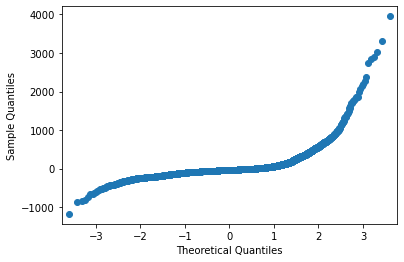

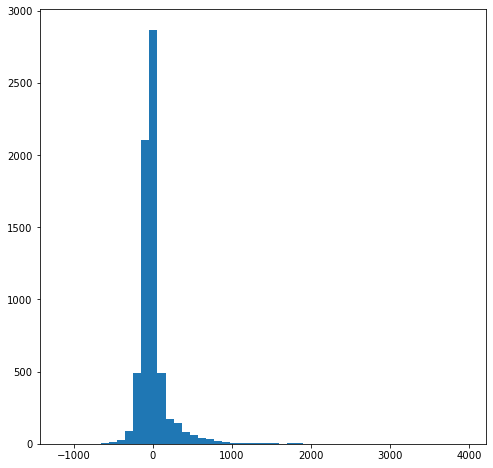

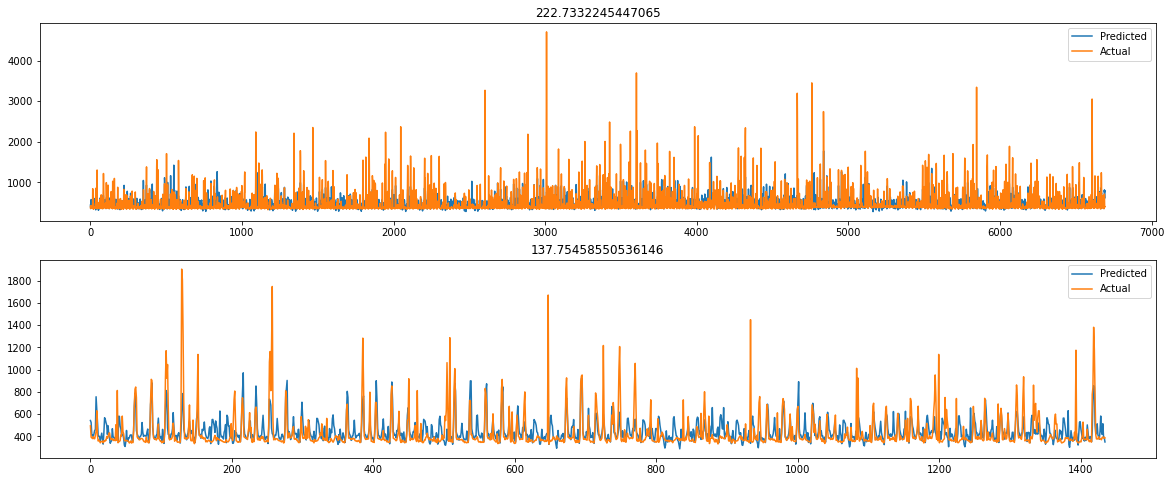

In [47]:
f = sm.qqplot(trained_model.resid)
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.hist(trained_model.resid, 50)

Y_train_pred = trained_model.predict(X_train)
Y_test_pred = trained_model.predict(X_test)
rmse_train = numpy.sqrt(numpy.mean((Y_train_pred - Y_train)**2))
rmse_test = numpy.sqrt(numpy.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(numpy.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_train_pred)), Y_train, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(numpy.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

Further analysis suggests:
* Our model is not looking too good in terms of validity, the residuals are very much not normally distributed
* We don't appear to be overfitting, performance looks similar between both training and testing data, with the testing data actually better.
* On the whole, our model seems to have captured the major trends in the data with big peaks seeming to be in the right spot, but lots of smaller peaks are missed.

## SKLearn's Regression Function

Let's now stop using statsmodels. This is not due to any fault with statsmodels OLS method (it's very good), but rather due to it's regularised counterparts (which we'll get to) being a bit less great, and sklearn's being much faster. As such, we'll switch to the implementation in sklearn. This is bit less flashy than statsmodels, in that we don't get the nice summary and all the nice statistics. In particular, we don't get p-values (which is a bit annoying), but we do get the same results.

Below, we'll fit the same model, and print out the model parmaeters (the coefficients) and the $R^2$ (the score in sklearn's terminology). We can see they are the same as we have above.

In [16]:
model_sk = LinearRegression(fit_intercept = False).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
print(model_sk.coef_)
print(model_sk.score(X_train.to_numpy(), Y_train.to_numpy()))

[ 1.19938864e+02  4.61592067e-02  2.44312577e-01  2.73459193e+00
  2.63574141e-01  1.33430958e+00  1.98337745e-01 -1.05823091e-01
  7.73394850e-01 -5.03135914e+01  3.36517123e+01 -4.19974360e+01
 -7.06742040e+01 -5.71500846e+00  1.28068333e+02  1.15419107e+02
  5.29130771e+01  2.70021429e+00 -8.69349738e+01 -9.43840966e+01
 -1.21303151e+02 -1.26509303e+02 -1.65419240e+02 -1.88601174e+02
 -1.53197215e+02 -4.72961985e+01 -1.04622114e+02 -7.01731782e+01
 -4.81385423e+01 -4.40418011e+01 -7.05867400e+01 -6.02466842e+01]
0.2560188577011978


### Adding Complexity

Given that we haven't overfit, we have scope to add complexity to the model. Let's do that. We'll create fourth order polynomials terms for our timing data, and add the categoricals back to those. Note that I am exluding my categoricals from this process. Some APIs (and MATLAB for example) will include categoricals when computing higher order terms.

In [48]:
poly_transform = PolynomialFeatures(4)
X_poly = poly_transform.fit_transform(data_to_use.iloc[:,1:-1])
X_poly = numpy.concatenate([X_poly, dummies], axis=1)
print(X_poly.shape)
X_train_poly = X_poly[0:training_samples, :]
X_val_poly = X_poly[training_samples:(training_samples + validation_samples), :]
X_test_poly = X_poly[(training_samples + validation_samples):, :]
print(X_train_poly.shape)
print(X_val_poly.shape)
print(X_test_poly.shape)

(9563, 518)
(6694, 518)
(1434, 518)
(1435, 518)


In [50]:
X_poly

array([[  1.    ,  98.99  ,  70.225 , ...,   0.    ,   0.    ,   0.    ],
       [  1.    , 105.05  ,  75.5675, ...,   0.    ,   0.    ,   0.    ],
       [  1.    , 100.11  ,  69.6125, ...,   0.    ,   0.    ,   0.    ],
       ...,
       [  1.    , 112.32  , 114.025 , ...,   1.    ,   0.    ,   0.    ],
       [  1.    , 108.3925, 105.215 , ...,   0.    ,   1.    ,   0.    ],
       [  1.    , 102.23  ,  91.8425, ...,   0.    ,   0.    ,   1.    ]])

In [18]:
model_poly = LinearRegression(fit_intercept = False).fit(X = X_train_poly, y = Y_train)
print(model_poly.coef_)
print(model_poly.score(X_train_poly, Y_train))

[ 7.25929828e+03  3.08013885e+01  1.73612155e+02 -2.82965770e+02
  1.22736893e+01 -3.47461237e+02 -1.73607155e+02 -1.82408389e+02
  4.26804291e+02  2.26464646e-01 -3.23027550e-01 -9.09410696e-01
  5.70653872e-01 -2.41064711e+00  8.14677197e-01 -4.30570449e-01
 -1.18448623e+00  3.15168842e-01  7.01169234e-01 -1.93095510e+00
  1.35712329e+00 -4.97286623e+00 -3.57177036e-01 -5.93249936e-01
 -6.12263849e-01 -8.41784702e-01  9.88785781e+00  7.12875383e+00
  1.26264200e+00  4.41461914e+00  1.62648341e-01 -2.83233466e-01
  1.58222334e+00  1.61479918e+00 -3.71861209e+00  1.61359397e+00
  6.64440928e+00 -2.34243139e+00  4.25497907e+00  8.78195730e-01
  6.74086149e-01 -1.45170783e+01  1.50838960e+00  3.73540269e-01
 -1.48383923e+00 -7.73608780e-05  1.00149475e-03 -2.12152223e-03
 -4.54067842e-04 -5.11663570e-03  1.73087479e-04  2.48469051e-04
  3.80541389e-04 -1.32956939e-03  6.87027559e-04 -5.05481054e-04
  1.11603109e-02 -2.12794987e-03  2.01747405e-03  6.53998215e-04
 -7.33897836e-04 -6.93738

Looking at our model:
* It's big, we have a lot of terms, and while we don't have a nice list of p-values here, it's easily to imagine that manually tidying these is not exactly practical
* Our $R^2$ is still not that great

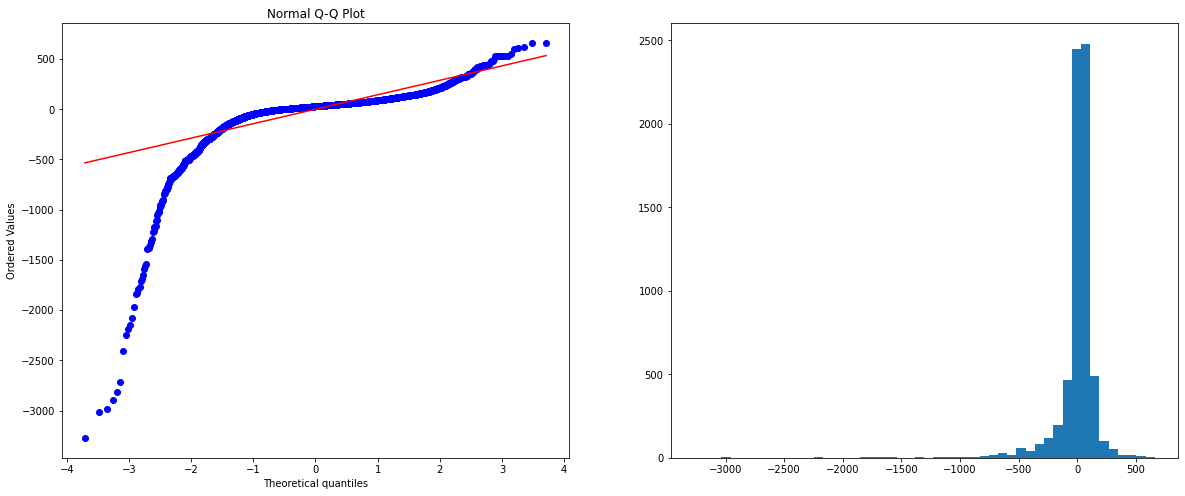

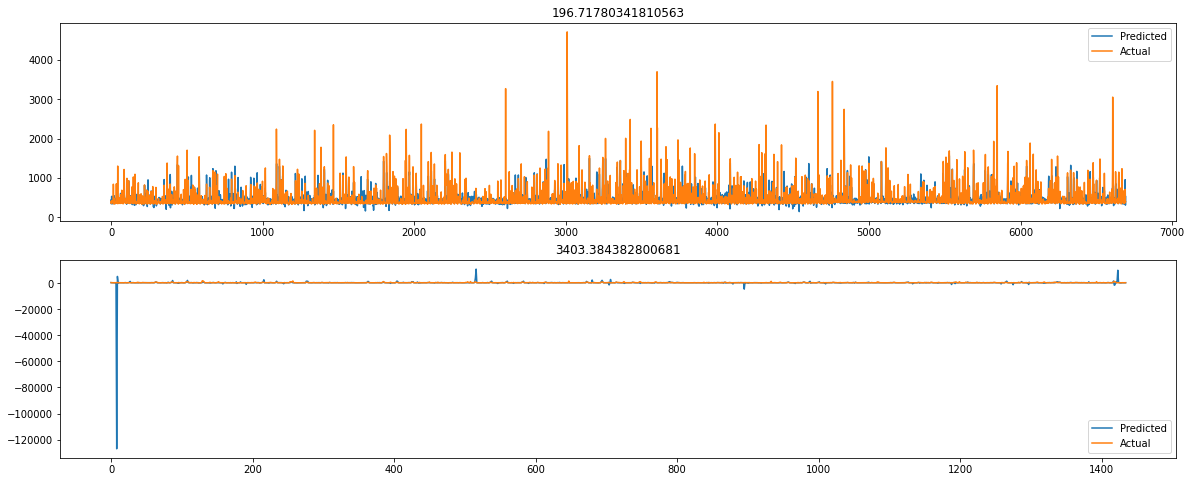

In [19]:
residuals = model_poly.predict(X_train_poly) - Y_train
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Normal Q-Q Plot")
ax = fig.add_subplot(1, 2, 2)
ax.hist(residuals, 50)

Y_train_poly_pred = model_poly.predict(X_train_poly)
Y_test_poly_pred = model_poly.predict(X_test_poly)
rmse_train = numpy.sqrt(numpy.mean((Y_train_poly_pred - Y_train)**2))
rmse_test = numpy.sqrt(numpy.mean((Y_test_poly_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(numpy.arange(len(Y_train_pred)), Y_train_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_train_pred)), Y_train, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(numpy.arange(len(Y_test_pred)), Y_test_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

Further analysis shows:
* The model is still not showing a Gaussian distribution of residuals
* We have some severe prediction errors going on. We've gotten more accurate on the training data, and less accurate on the testing data, with a couple of massive errors.

At this point, we're overfitting, and we're starting to get some interesting errors in the testing data. Ideally at this point, we'd simplify our model, which means removing terms. However, doing this manually (i.e. going through and identifying poor terms, removing them, etc) is not really practical with a model of this size. Hence, we'll use regularisation.

## Ridge (L2) Regularisation

Ridge regression, named for the former game show host Glenn Ridge (I made that up, it actually isn't), has the following form:
$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2 + \lambda \sum_{j=0}^p w_j^2$

This looks a fair bit like OLS regression, but with $\lambda \sum_{j=0}^p w_j^2$ tacked onto the end. This is the "L2 penalty term", and while that sounds odd, it just means the sum of squared values of the terms (i.e. all of our learned coefficients).

Note that there is a scale out the front of all this, $\lambda$. This determines how strong the regularisation is. If $\lambda = 0$, then this whole thing reverts to regular least squares regression. As it gets bigger and bigger, the regularisation term can dominante and make the weights small (which is what this term is trying to do), as this term becomes more important than actually fitting the data.

The overall impact of the penalty term is to promote small weights, based on the intuition that a small change in the input should lead to a small change in the output.

Let's start with a Ridge model with an arbitrary value of $\lambda$.

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.94997e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


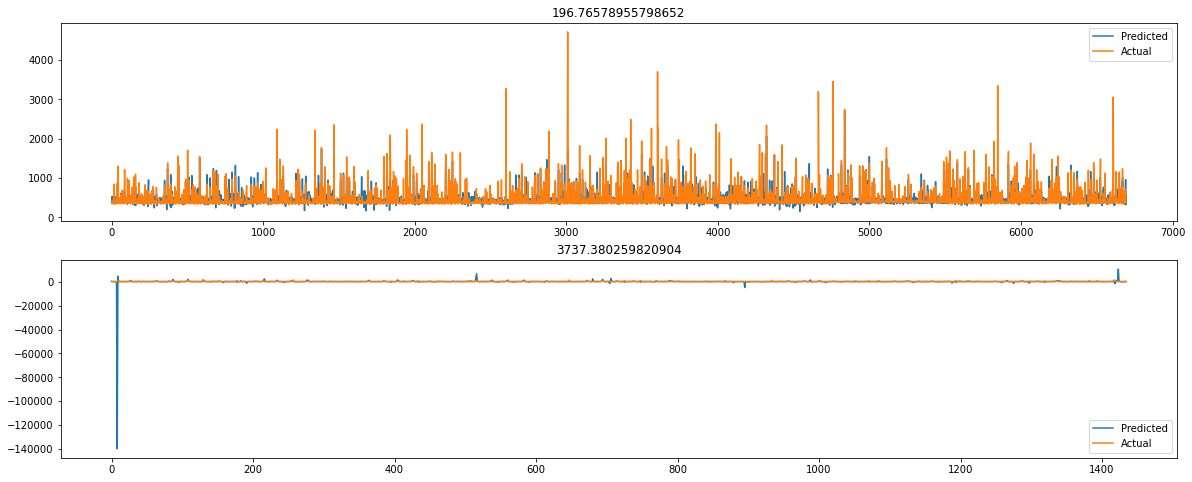

In [51]:
trained_model_poly_ridge = Ridge(fit_intercept=False, alpha=1).fit(X = X_train_poly, y = Y_train)

Y_train_poly_pred = trained_model_poly_ridge.predict(X_train_poly)
Y_test_poly_pred = trained_model_poly_ridge.predict(X_test_poly)
rmse_train = numpy.sqrt(numpy.mean((Y_train_poly_pred - Y_train)**2))
rmse_test = numpy.sqrt(numpy.mean((Y_test_poly_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(numpy.arange(len(Y_train_pred)), Y_train_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_train_pred)), Y_train, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(numpy.arange(len(Y_test_pred)), Y_test_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend()

It's fair to say our model is not great. Why? Quite simply we chose a poor value of $\lambda$.

What we need to do is consider a range of values, and find the one that's best. Let's do that now.

In [52]:
lambdas = numpy.arange(0, 500, 2)
rmse_train = []
rmse_validation = []
for l in lambdas:
    trained_model_poly_ridge = Ridge(fit_intercept=False, alpha=l).fit(X = X_train_poly, y = Y_train)
    rmse_train.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_train_poly) - Y_train)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_val_poly) - Y_val)**2)))

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.22421e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.93099e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.59234e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.14172e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/envs/cab420-env/lib/pytho

We get a lot of warnings, and looking at the results, we really don't see much variation in accuracy with $\lambda$. We could try a bigger range of $\lambda$, and we'd get somewhere eventually, but there's something we can do to the data to help.

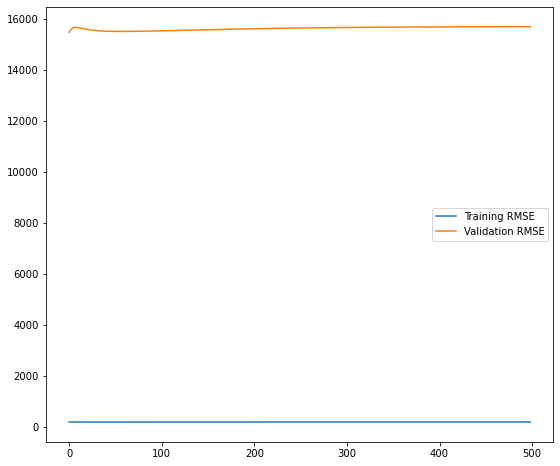

In [53]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
ax.plot(lambdas, rmse_train, label='Training RMSE')
ax.plot(lambdas, rmse_validation, label='Validation RMSE')
ax.legend();

Let's have a look at the distribution of our data. We'll run a boxplot over the polynomial terms. I don't care about the categorical terms here as they are either 1 or 0, so aren't very interesting from a statistical point of view.

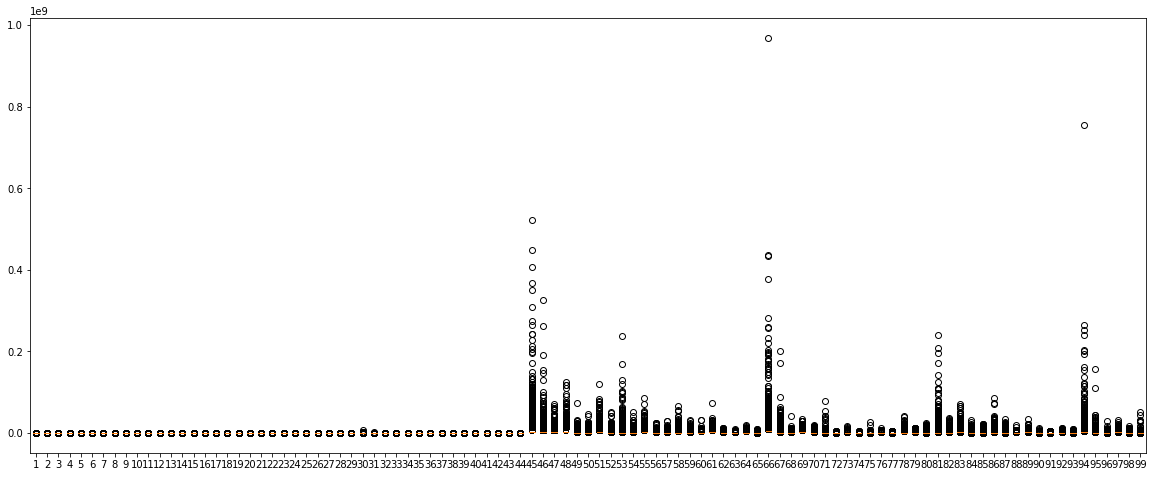

In [23]:
X_poly = poly_transform.fit_transform(data_to_use.iloc[:,1:-1])
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_poly[:,1:100]);

Looking at the above, we can clearly see that we have some variables with a much greater range than others. Note that I'm just looking at the first 100 here, it get's even more extreme in some of the later variables.

This variation in range of values has a direct impact on the model weights that we learn. Consider:
* A variable with a very large range, this will need only a small weight to have a large impact on the output, as there will naturally be high variation in high variation in the variable
* A variable with a very small range, this will need a large wieght to have a large impact on the output, as there will naturally be low variation in the variable

However, our regularisation has no idea about what the range of a variable is, and thus what sort of weight might be "reasonable". It will try to minimise all weights equally (while maximising accuracy), which means that variables with a large range can distort results.

### Standardisation

The solution to this issue is standardisation. This does the following:
$\hat{x_i} = \frac{x_i - \mu}{\sigma}$
where:
* $\hat{x_i}$ is a standardised sample
* $x_i$ is the original data point
* $\mu$ is the mean of the data
* $sigma$ is the standard deviation of the data

After standardisation, out data will have a mean of 0, and a standard deviation of 1. By applying this to each dimension, we end up with all variables having a mean of 0 and standard deviation of 1, and thus our regularised regression can better consider all the terms equally.

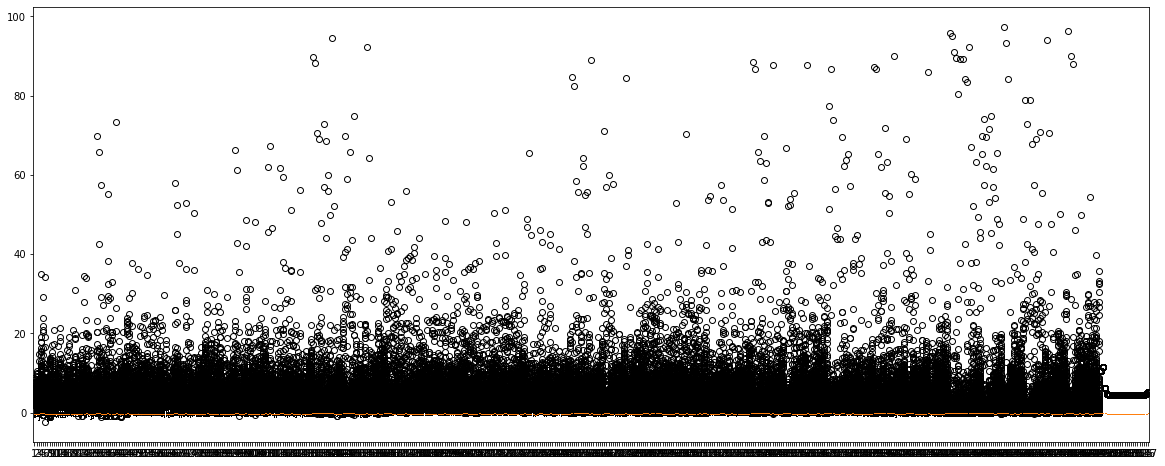

In [54]:
mu = numpy.mean(X_poly[:,1:],0)
sigma = numpy.std(X_poly[:,1:],0)
X_poly = (X_poly[:,1:] - mu) / sigma
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_poly);

In [57]:
mu.shape
X_poly[:,1:].shape

(9563, 516)

The plot of our standardised data looks much more uniform now. Note that our data is still a bit skewed in that we only have outlier on one side of the mean, which is a result of there being a lower bound on travel times (i.e. 0, as cars do not go faster than the speed of light), yet no upper bound.

We'll now recompute out training and testing sets, and we'll also standardise our output variable for consistency. We save the mean and std.dev when we do this so we can get back to the original data if we wish.

In [58]:
X_poly = numpy.concatenate([X_poly, dummies], axis=1)

Y_mu = numpy.mean(Y)
Y_sigma = numpy.std(Y)
Y_std = (Y - Y_mu) / Y_sigma

X_train_poly = X_poly[0:training_samples, :]
Y_train = Y_std[0:training_samples]
X_val_poly = X_poly[training_samples:(training_samples + validation_samples), :]
Y_val = Y_std[training_samples:(training_samples + validation_samples)]
X_test_poly = X_poly[(training_samples + validation_samples):, :]
Y_test = Y_std[(training_samples + validation_samples):]

### (Glenn) Ridge with Standardised Data

Let's repeat the ridge regression with standardised data.

Let's also take a minute to break down exactly what we're doing here:
* We're going to select a range of values for $\lambda$ to try
* For each value of $\lambda$, we'll fit a model, and then compute the RMSE on the training and validation data
* We're then plotting these RMSE's. Ultimatley, we want the model that achieves the lowest RMSE on the **validation data**

Why the validation data you ask? Because the accuracy on the training data will only go down as $\lambda$ increases. Remember the equation we're trying to solve here:

$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2 + \lambda \sum_{j=0}^p w_j^2$

As $\lambda$ increases, less emphasis is given to the first term which is concerned with fitting the training data. As such, we will get the best fit to the training data when $\lambda = 0$.

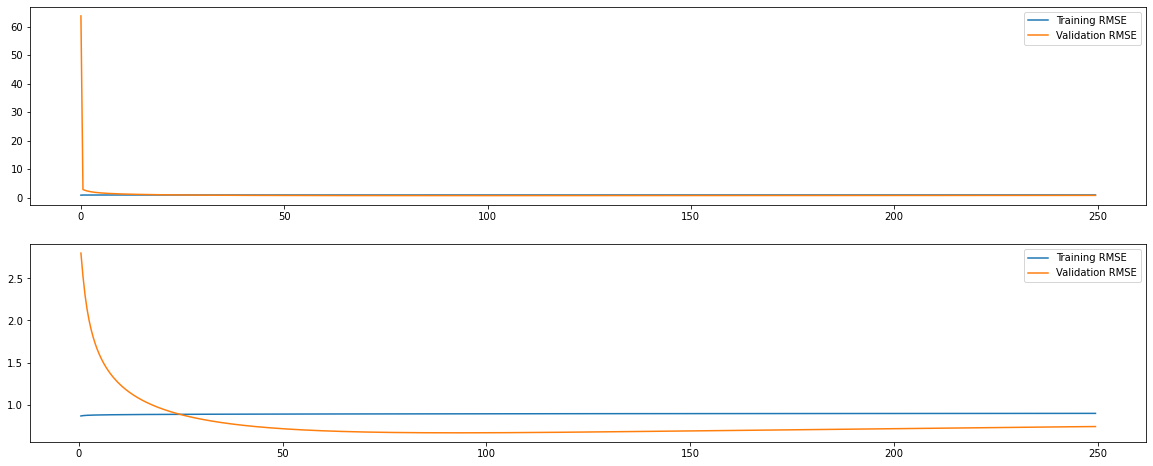

In [59]:
lambdas = numpy.arange(0, 250, 0.5)
rmse_train = []
rmse_validation = []
coeffs = []
for l in lambdas:
    trained_model_poly_ridge = Ridge(fit_intercept=False, alpha=l).fit(X_train_poly, Y_train)
    coeffs.append(trained_model_poly_ridge.coef_)
    rmse_train.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_train_poly) - Y_train)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_val_poly) - Y_val)**2)))
    
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(lambdas, rmse_train, label='Training RMSE')
ax.plot(lambdas, rmse_validation, label='Validation RMSE')
ax.legend();
ax = fig.add_subplot(2, 1, 2)
ax.plot(lambdas[1:], rmse_train[1:], label='Training RMSE')
ax.plot(lambdas[1:], rmse_validation[1:], label='Validation RMSE')
ax.legend();

We now see a much more noticeable difference as $\lambda$ changes. Remember that $\lambda=0$ is standard regression (no regularisation penalty term).

array([[-4.49897907e-02, -2.22530412e-01, -3.99554260e-01, ...,
        -7.68338534e-03, -9.36583053e-03, -4.68480698e-03],
       [ 2.44743138e-02, -1.04463010e-01, -3.02433435e-01, ...,
        -9.26647803e-03, -1.07745145e-02, -5.97839902e-03],
       [ 5.54714541e-02, -4.84910872e-02, -2.43648721e-01, ...,
        -1.06643176e-02, -1.20775988e-02, -7.12417717e-03],
       ...,
       [ 2.76854294e-02, -2.13414362e-04,  4.04289008e-02, ...,
        -7.35824891e-03, -9.63069925e-03, -6.08569179e-03],
       [ 2.76579246e-02, -2.08516641e-04,  4.04221636e-02, ...,
        -7.34919125e-03, -9.62258423e-03, -6.07941901e-03],
       [ 2.76304964e-02, -2.03636446e-04,  4.04153840e-02, ...,
        -7.34015424e-03, -9.61448727e-03, -6.07316001e-03]])

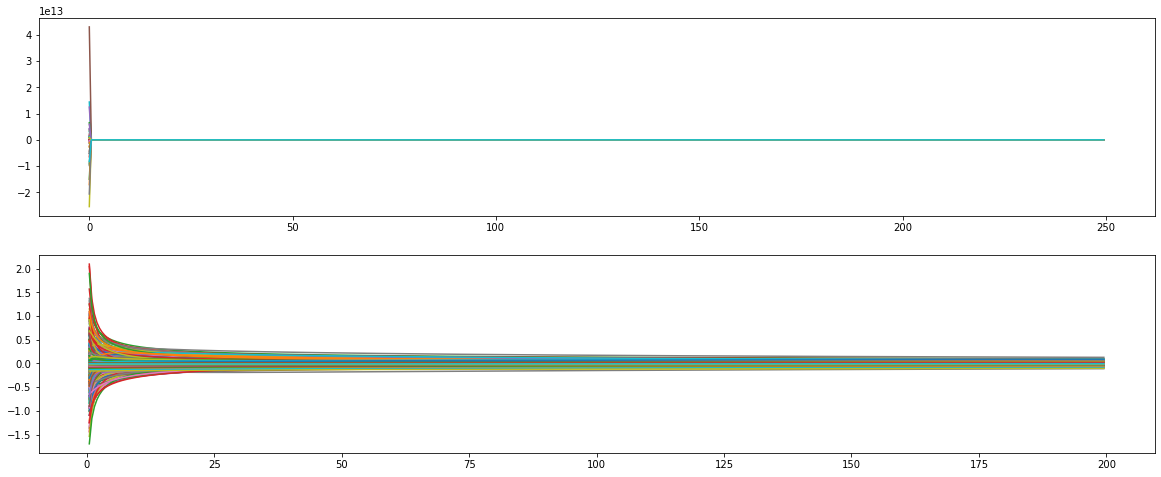

In [61]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(lambdas, coeffs);
coeffs = numpy.array(coeffs)
ax = fig.add_subplot(2, 1, 2)
ax.plot(lambdas[1:400], coeffs[1:400,:]);

In [70]:
print(coeffs[1:400,:].shape)
print(lambdas[1:400].shape)


(399, 540)
(399,)


The two above plots show how the coefficients (model parameters) vary as $\lambda$ changes. The first plot shows the whole range, the second just a subsection of it to make it easier to see what's happening. What we see is that as $\lambda$ increases, values on the whole get small (though some may still increase, at least for a while). 

Critically, we see that although values get small, none go to zero. This means that some terms get supressed, but not eliminated.

From this we can easily pick out the best value of $\lambda$ and train a model using that, and we can evaluate this model and get a sense for how well it works.

Note that in this evaluation, we convert the test data back from the standardised range into the original range to make it easy to compare this model with our earlier linear models. We can convert the data back simply by multiplying by the standard deviation, and adding the mean (i.e. the inverse of what we did to standardise it).

In [74]:
numpy.argmin(rmse_validation)

185

92.5


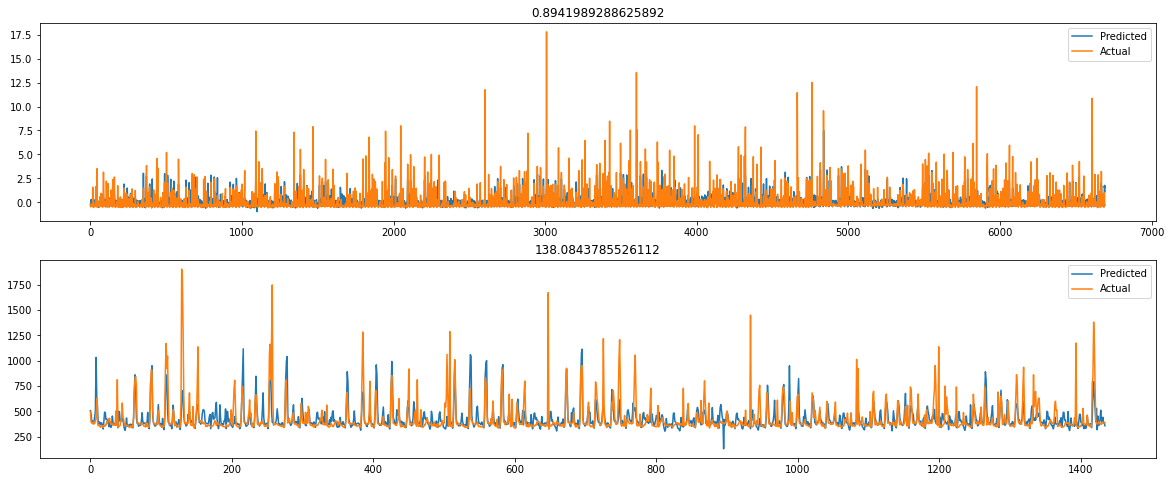

In [71]:
best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)
trained_model_poly_ridge = Ridge(fit_intercept=False, alpha=best_lambda).fit(X_train_poly, Y_train)

Y_train_poly_pred = trained_model_poly_ridge.predict(X_train_poly)
Y_test_poly_pred = trained_model_poly_ridge.predict(X_test_poly)
rmse_train = numpy.sqrt(numpy.mean((Y_train_poly_pred - Y_train)**2))
rmse_test = numpy.sqrt(numpy.mean(((Y_test_poly_pred*Y_sigma + Y_mu) - (Y_test*Y_sigma + Y_mu))**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(numpy.arange(len(Y_train_pred)), Y_train_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_train_pred)), Y_train, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(numpy.arange(len(Y_test_pred)), Y_test_poly_pred*Y_sigma + Y_mu, label='Predicted')
ax.plot(numpy.arange(len(Y_test_pred)), Y_test*Y_sigma + Y_mu, label='Actual')
ax.set_title(rmse_test)
ax.legend();

Comparing this to our linear method, it works much better - though still not quite as well as the simpler model that we started with. 

Note that our value of $\lambda$ is not totally optimal, we've used a large step when evaluating possible values (0.5), and we could refine this further, but that's not going to give us a massive change in performance either.

## Lasso and L1 Regularisation

Lasso regression modifies our standard least squares linear regression by adding an L1 penalty term, and this makes our objective look like this:

$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2 + \lambda \sum_{j=0}^p |w_j|$

The "L1 penalty term" is a lot like our L2 penalty term, but it is the sum of absolute values of the terms (i.e. all of our learned coefficients), rather than sum of squares, i.e.:
$\lambda \sum_{j=0}^p |w_j|$

Note that once again, there is a scale out the front of all this, $\lambda$. This plays the same role as in ridge regression, and again if $\lambda = 0$, then this whole thing reverts to regular least squares regression. Again, the presence of this variable means that we need to work out what a good value of $\lambda$ is as well.

To do this, let's repeat what we did in the second half of the ridge regression investigation, i.e. using standardised data and looping over a range of $\lambda$'s.

/tmp/ipykernel_10454/3729595695.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  trained_model_poly_lasso = Lasso(fit_intercept=False, alpha=l).fit(X_train_poly, Y_train)
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+03, tolerance: 7.846e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV 

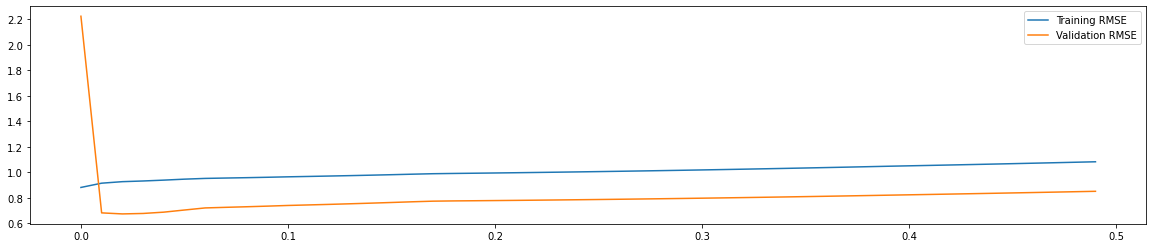

In [75]:
lambdas = numpy.arange(0.0, 0.5, 0.01)
rmse_train = []
rmse_validation = []
coeffs = []
for l in lambdas:
    trained_model_poly_lasso = Lasso(fit_intercept=False, alpha=l).fit(X_train_poly, Y_train)
    coeffs.append(trained_model_poly_lasso.coef_)
    rmse_train.append(numpy.sqrt(numpy.mean((trained_model_poly_lasso.predict(X_train_poly) - Y_train)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((trained_model_poly_lasso.predict(X_val_poly) - Y_val)**2)))
    
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.plot(lambdas, rmse_train, label='Training RMSE')
ax.plot(lambdas, rmse_validation, label='Validation RMSE')
ax.legend();

We see a similar trend here to what we saw above - though it's actually much clearer here. Considering the validation accuracy, we start off not so great, get better until we reach some minimum, and then start to get worse again. Eventually, things will stop changing and we'll get to a constant model.

Don't worry about the warnings we got as these relate to the $\lambda = 0$ case, i.e. the linear model, and there's really not a lot of need to call Lasso (or Ridge) with $\lambda = 0$ as we should just be using linear regression in these cases.

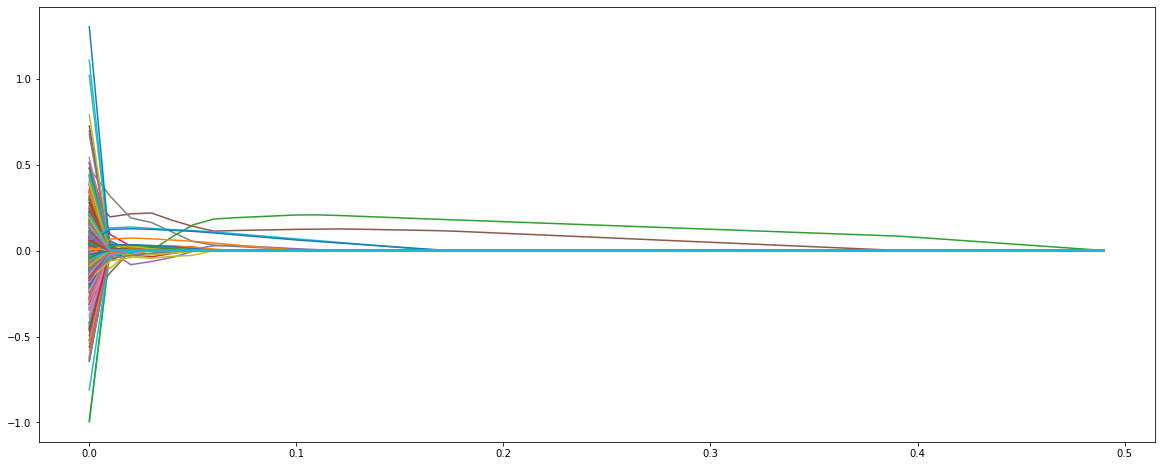

In [76]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(lambdas, coeffs);

Plotting the trace of the coefficients, we see a much more interesting plot than we saw for ridge. The really big thing to note is that weights can go to 0, and by the end of the plot ($\lambda = 0.5$), all the weights are 0, i.e. we now have a constant model. Lasso will allow us to outright eliminate variables, rather than just supress them the way that ridge does.

Once again, we can select our best value of $\lambda$ and evaluate our model. Again, this value is likely not the most optimal $\lambda$ possible, but even if we tweak this further we won't see a huge change in performance.

In [77]:
best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)

0.02


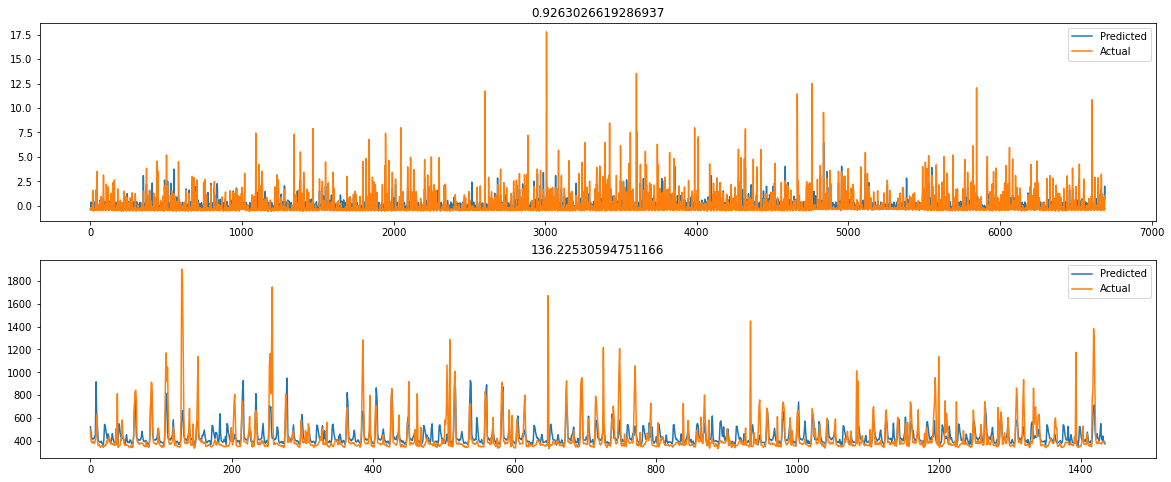

In [79]:
trained_model_poly_lasso = Lasso(fit_intercept=False, alpha=best_lambda).fit(X_train_poly, Y_train)

Y_train_poly_pred = trained_model_poly_lasso.predict(X_train_poly)
Y_test_poly_pred = trained_model_poly_lasso.predict(X_test_poly)
rmse_train = numpy.sqrt(numpy.mean((Y_train_poly_pred - Y_train)**2))
rmse_test = numpy.sqrt(numpy.mean(((Y_test_poly_pred*Y_sigma + Y_mu) - (Y_test*Y_sigma + Y_mu))**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(numpy.arange(len(Y_train_pred)), Y_train_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_train_pred)), Y_train, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(numpy.arange(len(Y_test_pred)), Y_test_poly_pred*Y_sigma + Y_mu, label='Predicted')
ax.plot(numpy.arange(len(Y_test_pred)), Y_test*Y_sigma + Y_mu, label='Actual')
ax.set_title(rmse_test)
ax.legend();

Having a look at how many terms we have left, we can see that our best model has only keep 26 terms out of ~500.

In [80]:
sum(trained_model_poly_lasso.coef_ != 0)

30

## Comparing Models

Let's quickly compare our models - the ridge and lasso regressors.

Ridge R**2 = 0.26710770220991376
Lasso R**2 = 0.31702843271163295


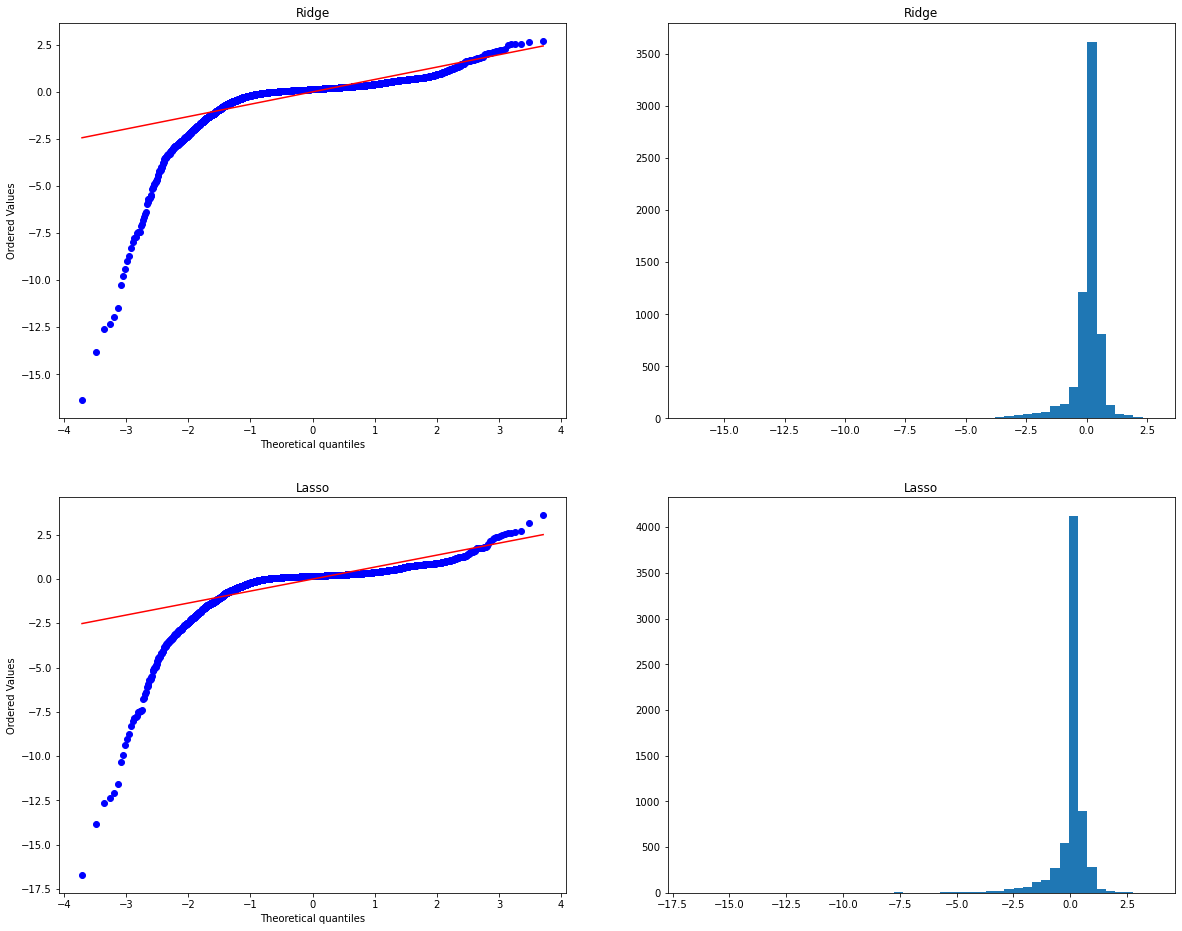

In [81]:
fig = plt.figure(figsize=[20, 16])

residuals = trained_model_poly_ridge.predict(X_train_poly) - Y_train
ax = fig.add_subplot(2, 2, 1)
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Ridge")
ax = fig.add_subplot(2, 2, 2)
ax.hist(residuals, 50)
ax.set_title("Ridge")

residuals = trained_model_poly_lasso.predict(X_train_poly) - Y_train
ax = fig.add_subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Lasso")
ax = fig.add_subplot(2, 2, 4)
ax.hist(residuals, 50)
ax.set_title("Lasso")
print('Ridge R**2 = ' + str(trained_model_poly_lasso.score(X_train_poly, Y_train)))
print('Lasso R**2 = ' + str(trained_model_poly_ridge.score(X_train_poly, Y_train)))

From these plots and $R^2$ values, and comparing to the linear model above, we can see that regularisation has not magically made everything better.

In fact, what we see is that our $R^2$ values are worse, yet the model performs better on the test set. This may seem odd, but remember that $R^2$ considers the quality of fit to the training set. While we want a high $R^2$, we also wish to avoid overfitting. Ultimatley the way to maximse $R^2$ is to have a perfect fit to the training data, which in many practical cases is sadly likely to indicate over fitting. This however does not mean that $R^2$ is of no use, it just needs to be considered in combination with other details such as performance on test sets.

## Final Thoughts

So what have we learned today?

Regaularised regression gives us a way to deal with large input spaces (i.e. lots of variables) and improve performance without the need to manually identify and remove poor or duplicate variables. However, it's not a silver bullet and does not guarantee amazing performance. Consider our initial model (using just the 8 counters and the time) - that model is still more accurate than our final ridge and lasso models; though ridge and lasso made a large difference when considering the greatly expanded input space with the higher order terms.

Comparing ridge and lasso, the formulation is very similar, but the end result is quite different. Ridge will supress terms, lasso can outright eliminate them by setting weights to 0. Even with a massive value of $\lambda$ ridge can't get terms to 0 (though they will get increasingly close). For regularisation, standardising data (subtract the mean, divide by the standard deviation) can help the scale between dimensions changes. It also makes visualisation easier with the trace plots. Finally, for Lasso and Ridge, our usual analysis methods of qqplots, and so on are valid, but we don't have p-values.

#### Selecting $\lambda$

In this example we've used pretty coarse estimations for $\lambda$. Using a smaller step size will lead to a more accurate model, but will probably also take a long, long time to run. If you want to be more accurate, consider an iterative approach, i.e:
* Start with a coarse search range, let's say $0.1$ to $10$ in increments of $0.1$. Let's pretend that the best result you get is for $\lambda = 1.2$
* Now conduct a fine search around that range, perhaps $1.1$ to $1.3$ in steps of $0.005$. Now maybe the best value is for $\lambda=1.185$
* You now, if you were really keen, go again in a range around the current best estimate.

You still need to make an initial esimate of $\lambda$ however, and there are a couple of things to note. If you determine that your best value is $0$, this means that regularisation is not helping. This may actually be a valid result, but may also indicate that you have your step size too big, i.e. the first non-zero value of $\lambda$ may be applying too much regularisation. Try reducing the step size to a much smaller value and search at values very near 0, and confirm that even a very small amount of regularisation has no positive impact.

The other thing you may find is that your best value of $\lambda$ is the last one you check, i.e. you search from $0$ to $100$ and find $\lambda = 100$ is best. It's possible (even likely) that a large value of $\lambda$ will be better still. Try increasing the search range to find the point at which the validation accuracy reaches a minimum.

#### Notation

Finally some notes on notation. The regularisation term we use for lasso regression, $\sum_{j=0}^p |w_j|$, is oftern refered to as an L1 Norm, and may also be written as $||w_j||_1$. Similarly, the ridge regression term, an L2 norm, may be written as $||w_j||_2$. 

The other norm that you may encounter in machine learning is the L0 norm, $||w_j||_0$. This is actually the number of non-zero elements in the vector and this cannot be directly optimised for. Thus while you may see the L0 norm appear in theory in some places (sparse coding for example), in practice it is usually approximated by the L1 norm.